<div style="float:right">
<table style="width:100%">
  <tr>
    <th>NO.</th>
    <th>Name</th>
    <th>E-mail</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Abdullah Abdelhakeem</td>
    <td>abdullah.abdelhakeem25@gmail.com</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Mohamed Sebaie</td>
    <td>mohamedsebaie1@gmail.com</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Mahmoud Salama</td>
    <td>mahmoudsalama748@yahoo.com
</td>
  </tr>
  
</table>

</div>

<center>
<h1><font size="+4">Distracted Driver Detection</font></h1>
</center>

---

<CENTER>
<H1 style="color:red">
<h2>TechnoColabs</h2>
<time datetime="2022-01-18">18 January 2022</time>
</H1>
</CENTER>

# Project Steps

## Load The Data

In [ ]:
%%capture
import time
import gdown

!mkdir /content/project
%cd /content/project

#Download Data and The Model
!gdown --id 1-1hvH1TZ5qdepffU1n2OOgtXJM2Eihcf
!gdown --id 1P9r7pCc-5eTmW4krT4GZ1F6w_miTtxJA
!gdown --id 1HZcv5udEt9UBQb-SuWRxxid9cO11JP3-

!unzip Distracted_Driver_Detection_Data.zip
!rm Distracted_Driver_Detection_Data.zip

## Import Dependencies

In [ ]:
%%capture

%cd /content/
!pip install onnx
!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git 
%cd onnx-tensorflow 
!pip install /content/onnx-tensorflow
%cd /content/project

In [ ]:
%%capture

%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import copy
import time
from math import exp
import random
import os
from PIL import Image
from IPython.display import display

import torch
import torchvision
from torch import nn, optim
from torchvision import models
from torch.functional import F
from torchvision import datasets, transforms
from torch.autograd import Variable
import onnx
from onnx_tf.backend import prepare
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from Distracted_Driver_Detection_Utils import *

## Preprocessing the Data

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size']=12

In [ ]:
SEED = 47

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/project/'
labels = pd.read_csv(data_dir+'driver_imgs_list.csv')
display(labels.head())

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
train_img_dir = os.path.join(data_dir, 'imgs/train')
test_img_dir = os.path.join(data_dir, 'imgs/test')

num_training_examples = 0
for fol in os.listdir(train_img_dir):
    num_training_examples += len(os.listdir(os.path.join(train_img_dir, fol)))

assert(num_training_examples == len(labels))

classes = {0:"Safe driving",1:"Texting(right hand)",2:"Talking on the phone (right hand)", 3:"Texting (left hand)",
           4:"Talking on the phone (left hand)", 5:"Operating the radio", 6:"Drinking", 7:"Reaching behind", 
           8:"Hair and makeup", 9:"Talking to passenger(s)"}

train_data = torchvision.datasets.ImageFolder(root = train_img_dir)

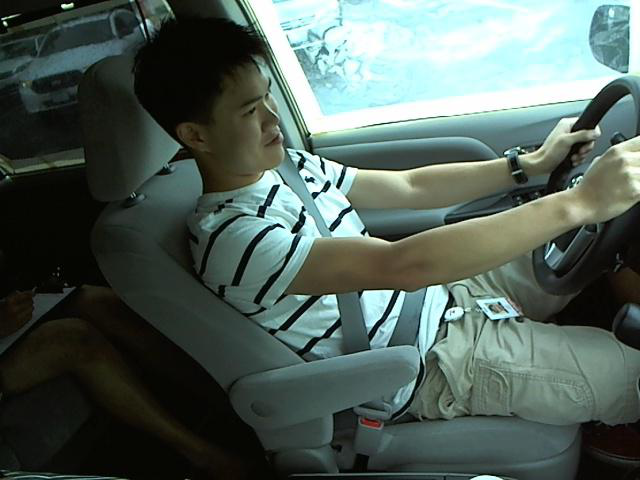

In [ ]:
train_data[4][0]

In [ ]:
labelss=labels.classname.map(train_data.class_to_idx)

In [ ]:
labelss

0        0
1        0
2        0
3        0
4        0
        ..
22419    9
22420    9
22421    9
22422    9
22423    9
Name: classname, Length: 22424, dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


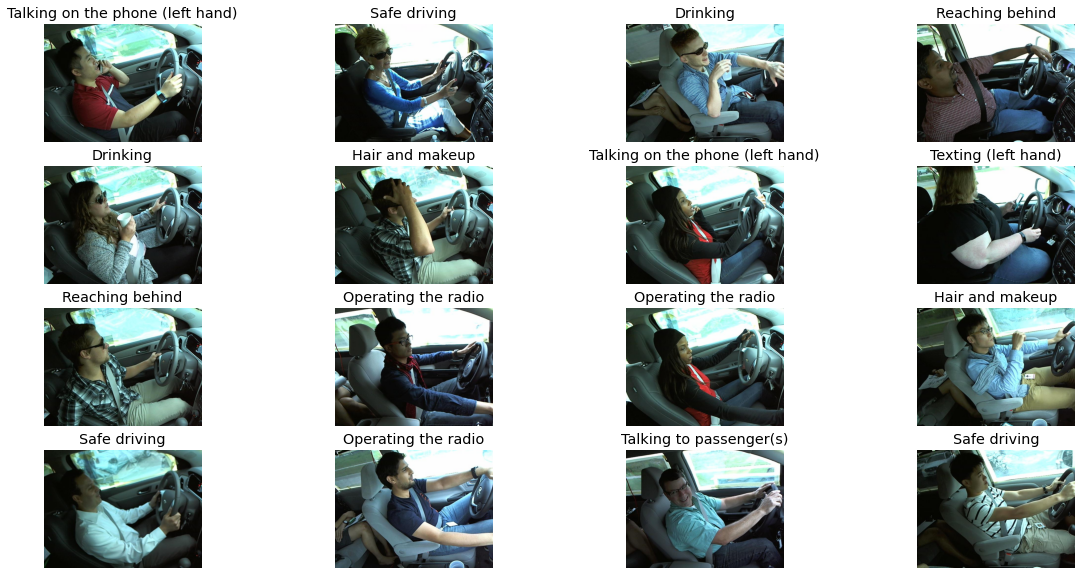

In [ ]:
N_IMAGES = 20
images = [(image, classes[label]) for image, label in [train_data[i] for i in random.sample(range(len(train_data)), N_IMAGES)]] 
plot_images(images)

In [ ]:
RATIO = 0.8

n_train_examples = int(len(train_data) * RATIO)
n_Test_Valid_examples = len(train_data) - n_train_examples
n_valid_examples = int(n_Test_Valid_examples/2)
n_Test_examples= n_Test_Valid_examples-n_valid_examples

train_data, Test_valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_Test_Valid_examples])

valid_data,test_data = torch.utils.data.random_split(Test_valid_data, 
                                           [n_valid_examples, n_Test_examples])


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
train_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
validation_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

test_transforms = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

train_data.dataset.transform = train_transforms
valid_data = copy.deepcopy(valid_data)
test_data  = copy.deepcopy(test_data)
valid_data.dataset.transform = validation_transforms

print(f'Number of Training examples: {len(train_data)}')
print(f'Number of Validation examples: {len(valid_data)}')
print(f'Number of Test examples: {len(test_data)}')

BATCH_SIZE = 256

train_iterator = DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE*2)

test_iterator = DataLoader(test_data, 
                                 batch_size = BATCH_SIZE*2)

Number of Training examples: 17939
Number of Validation examples: 2242
Number of Test examples: 2243


##Training and Save the Model

In [ ]:
model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features,10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model= model.to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-2)
epochs=20
model_name='ResNet18'
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,938 trainable parameters


In [ ]:
train_stats_ResNet18 = fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs)

Epoch: 01 | Epoch Time: 3m 11s
	Train Loss: 0.711 | Train Acc: 80.28%
	 Val. Loss: 0.126 |  Val. Acc: 96.84%
Epoch: 02 | Epoch Time: 3m 8s
	Train Loss: 0.074 | Train Acc: 98.18%
	 Val. Loss: 0.117 |  Val. Acc: 96.61%
Epoch: 03 | Epoch Time: 3m 8s
	Train Loss: 0.041 | Train Acc: 98.97%
	 Val. Loss: 0.160 |  Val. Acc: 94.51%
Epoch: 04 | Epoch Time: 3m 11s
	Train Loss: 0.045 | Train Acc: 98.88%
	 Val. Loss: 0.059 |  Val. Acc: 98.39%
Epoch: 05 | Epoch Time: 3m 10s
	Train Loss: 0.029 | Train Acc: 99.11%
	 Val. Loss: 0.088 |  Val. Acc: 97.70%
Epoch: 06 | Epoch Time: 3m 8s
	Train Loss: 0.028 | Train Acc: 99.22%
	 Val. Loss: 0.109 |  Val. Acc: 96.48%
Epoch: 07 | Epoch Time: 3m 8s
	Train Loss: 0.044 | Train Acc: 98.62%
	 Val. Loss: 0.059 |  Val. Acc: 97.76%
Epoch: 08 | Epoch Time: 3m 8s
	Train Loss: 0.015 | Train Acc: 99.60%
	 Val. Loss: 0.045 |  Val. Acc: 98.83%
Epoch: 09 | Epoch Time: 3m 9s
	Train Loss: 0.008 | Train Acc: 99.80%
	 Val. Loss: 0.026 |  Val. Acc: 99.27%
Epoch: 10 | Epoch Time: 3

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


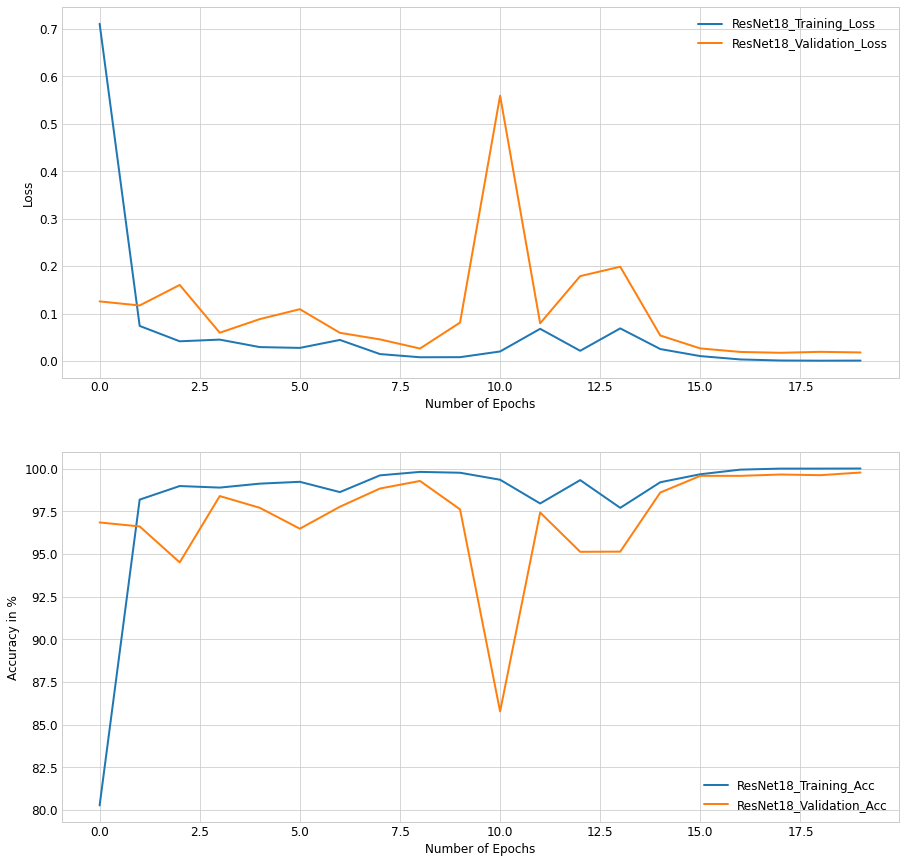

In [ ]:
plot_training_statistics(train_stats_ResNet18, model_name)

In [ ]:
test_loss, test_acc=evaluate(model, test_iterator, loss_criterion, device)
test_loss, test_acc

(0.022647632798179985, 0.9953125)

In [ ]:
PATH="/content/drive/MyDrive/Distracted_Driver_Detection_Project/model_ft.pth"

In [ ]:
torch.save(model.state_dict(), PATH)

## Load the Saved Weights

In [ ]:
modelWeightsPath="/content/project/model_ft.pth"

In [ ]:
model= loadModel(modelWeightsPath)

## Convert from Pytorch to Tensorflow Lite

In [ ]:
modelWeightsPath="/content/project/model_ft.pth"

In [ ]:
model = loadModel(modelWeightsPath)

In [ ]:
dummy_input = Variable(torch.randn(1, 3, 224, 224)).to(device)
torch.onnx.export(model, dummy_input, "model.onnx")
model = onnx.load('model.onnx')
tf_rep = prepare(model) 
tf_rep.export_graph("model.pb")

INFO:tensorflow:Assets written to: model.pb/assets


In [ ]:
!tflite_convert \
    --output_file=/content/model.tflite \
    --saved_model_dir=/content/project/model.pb \
    --input_arrays=tf_rep.inputs \
    --output_arrays=tf_rep.outputs 
    # --output_format=TFLITE \
    # --inference_type=QUANTIZED_UINT8 \
    # --inference_input_type=QUANTIZED_UINT8 

2022-01-19 01:44:35.576603: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-01-19 01:44:36.146038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-01-19 01:44:36.146090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-01-19 01:44:36.146101: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
Estimated count of arithmetic ops: 3.632 G  ops, equivalently 1.816 G  MACs
W0119 01:44:36.951108 139928256575360 lite.py:742] Buffer deduplication procedure will be skipped when flatbuffer library is not properly loaded


In [ ]:
class TensorflowLiteClassificationModel:
    def __init__(self, model_path, labels,transform,classes,image_size=224):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self._input_details = self.interpreter.get_input_details()
        self._output_details = self.interpreter.get_output_details()
        self.labels = labels
        self.image_size=image_size
        self.transform= transform
        self.classes=classes
    def run_from_filepath(self, image_path):
        image = Image.open(image_path)
        x = self.transform(image)
        x.unsqueeze_(0)
        x=x.cpu().detach().numpy()
        return self.run(x)

    def run(self, image):
        """
        args:
          image: a (1, image_size, image_size, 3) np.array

        Returns list of [Label, Probability], of type List<str, float>
        """

        self.interpreter.set_tensor(self._input_details[0]["index"], image)
        self.interpreter.invoke()
        tflite_interpreter_output = self.interpreter.get_tensor(self._output_details[0]["index"])
        probabilities = np.array(tflite_interpreter_output[0])
        exp_x=[exp(x) for x in probabilities]
        probabilities=[exp(x)/sum(exp_x) for x in probabilities]
        # create list of ["label", probability], ordered descending probability
        label_to_probabilities = []
        for i, probability in enumerate(probabilities):
            label_to_probabilities.append([self.labels[i], float(probability)])
        pClass=sorted(label_to_probabilities, key=lambda element: element[1])[-1]
        cls= self.classes[pClass[0]]
        p=pClass[1]
        return cls,p


In [ ]:
def test_tflite(img_path,tflite_model,labels,transform,classes):
  model = TensorflowLiteClassificationModel(tflite_model,labels,transform,classes)
  imge = mpimg.imread(img_path)
  imgplot = plt.imshow(imge)
  plt.show()
  cls,p= model.run_from_filepath(img_path)
  print(f"it is `{cls}`Class with Probability {p} %")

In [ ]:
imag="/content/project/imgs/test/"+random.choice(os.listdir("/content/project/imgs/test"))
imag

'/content/project/imgs/test/img_21602.jpg'

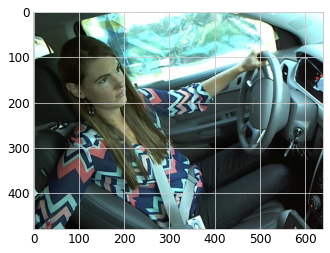

it is `Reaching behind`Class with Probability 0.9823863153109902 %


In [ ]:
test_tflite(imag,"/content/model.tflite",range(0,10),test_transforms,classes)

In [ ]:
model = TensorflowLiteClassificationModel("/content/model.tflite",range(0,10),test_transforms,classes)

In [ ]:
imge = mpimg.imread('/content/project/imgs/train/c4/img_100277.jpg')
imgplot = plt.imshow(imge)
plt.show()

In [ ]:
model.run_from_filepath("/content/project/imgs/train/c7/img_100201.jpg")

('Reaching behind', 0.9999997693267416)

## Prediction on Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


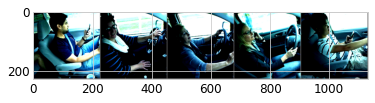

GroundTruth:
------------------------------
Texting (left hand)--
Talking to passenger(s)--
Operating the radio--
Talking on the phone (left hand)--
Texting (left hand)
************************************************************
Predicted:
------------------------------
Texting (left hand)--
Talking to passenger(s)--
Operating the radio--
Talking on the phone (left hand)--
Texting (left hand)


In [ ]:
PredictBatch(test_data,5,device,model)

(480, 640, 3)


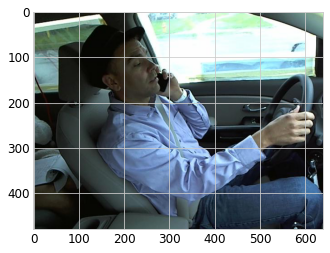

In [ ]:
imge = mpimg.imread('/content/project/imgs/train/c4/img_100277.jpg')
print(imge.shape)
imgplot = plt.imshow(imge)
plt.show()

In [ ]:
PredictClass("/content/project/imgs/train/c4/img_100277.jpg",test_transforms,device,model,classes)

ClassNo: 4 
ClassName: Talking on the phone (left hand)


'Talking on the phone (left hand)'

## Addtional

In [ ]:
# # Load TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_path="/content/model.tflite")
# interpreter.allocate_tensors()

# # Get input and output tensors.
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Test model on random input data.
# input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
# interpreter.set_tensor(input_details[0]['index'], input_data)

# interpreter.invoke()

# # The function `get_tensor()` returns a copy of the tensor data.
# # Use `tensor()` in order to get a pointer to the tensor.
# output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

______________________________________________________________